In [ ]:
# Author: Daniel Ourinson
# Last modified: 12/07/2025
# Tested with Python versions: 3.10, 3.11, 3.12, 3.13

**Analysis of the Economist's Democracy Index**

This analysis examines the level of democracy in various countries, as measured by the Economist's "Democracy Index" [1,2], and its correlation with key indicators such as press freedom [3], life expectancy [4], and the percentage of GDP spent on education [5].  
The objective is to assess the common assumption that there is a positive correlation between democracy and these indicators.  
The focus of this analysis is on observing and analyzing the data rather than interpreting or debating the implications of the results.

The Democracy Index scores range from 0 to 10, categorizing countries into the following regime types:  
0-4: Authoritarian regime  
4-6: Hybrid regime  
6-8: Flawed democracy  
8-10: Full democracy

First, let's impot all the necessary libraries and functions. 

In [276]:
# Importing all necessary libraries and functions
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Second, let's specify the folder paths for all the datasets that will be used in this analysis.

In [ ]:
# Defining the paths to the datasets. These are relative paths, assuming a folder named 'Input_DI' 
# is located at the same level as the Jupyter notebook file. This folder should contain all the necessary datasets.

# Democracy Index
path_dataset_democracy_index = "./Input_Datasets/Democracy_Index_2006_2023.csv"

# Population
path_dataset_population = "./Input_Datasets/Population.csv"

# Press freedom score
path_dataset_press_freedom = "./Input_Datasets/Press_Freedom.csv"

# Life expectancy
path_dataset_life_expectancy = "./Input_Datasets/Life_expectancy.csv"

# Education spending
path_dataset_education = "./Input_Datasets/Education.csv"

Let's upload and clean the raw data containing the Democracy Index [2].

In [280]:
# Create a function to load a dataset as a DataFrame (df) by specifying the file path and separator. The default separator is a comma
def csv_to_df(path,sep = ','):
    
    # Load the CSV file into a df using the provided path and separator
    df = pd.read_csv(path,sep=sep)
    
    # Display the first 5 rows of the df to inspect and get an initial impression of the data
    print(df.head())

    # Print a line of dashes for better visual separation
    print('---')

    # Print basic information about the df to understand its structure and contents
    print(df.info())

    # Return the df from the function for further use
    return df

# Call the function to load the Democracy Index dataset into a DataFrame
democracy_index = csv_to_df(path_dataset_democracy_index)

        Entity Code  Year  Democracy score
0  Afghanistan  AFG  2006             3.06
1  Afghanistan  AFG  2008             3.02
2  Afghanistan  AFG  2010             2.48
3  Afghanistan  AFG  2011             2.48
4  Afghanistan  AFG  2012             2.48
---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2765 entries, 0 to 2764
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Entity           2765 non-null   object 
 1   Code             2669 non-null   object 
 2   Year             2765 non-null   int64  
 3   Democracy score  2765 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 86.5+ KB
None


In [281]:
# Cleaning the df:

# Removing unnecessary columns from the df
democracy_index = democracy_index.drop(columns=['Code'])

# Renaming columns to more descriptive titles
democracy_index = democracy_index.rename(columns={'Entity': 'Country', 'Democracy score': 'Democracy_Index'})

# Removing fake countries
democracy_index = democracy_index[democracy_index['Country'] != 'North America']

print(democracy_index.head())

       Country  Year  Democracy_Index
0  Afghanistan  2006             3.06
1  Afghanistan  2008             3.02
2  Afghanistan  2010             2.48
3  Afghanistan  2011             2.48
4  Afghanistan  2012             2.48


In [282]:
# Defining the Democracy Index ranges for each regime type
bins = [0, 4, 6, 8, 10]

# Specifying the names of the regime types, with new lines added for better visualization in the graphs
regime_types = ['Authoritarian\nRegime','Hybrid\nRegime','Flawed\nDemocracy','Full\nDemocracy']

# Adding a new column for regime types by using pd.cut() to categorize the Democracy Index values
democracy_index['Type'] = pd.cut(democracy_index['Democracy_Index'], bins=bins, labels=regime_types, right=True, include_lowest=True)

Let's plot the distribution of countries by regime type for 2023 in Figure 1.

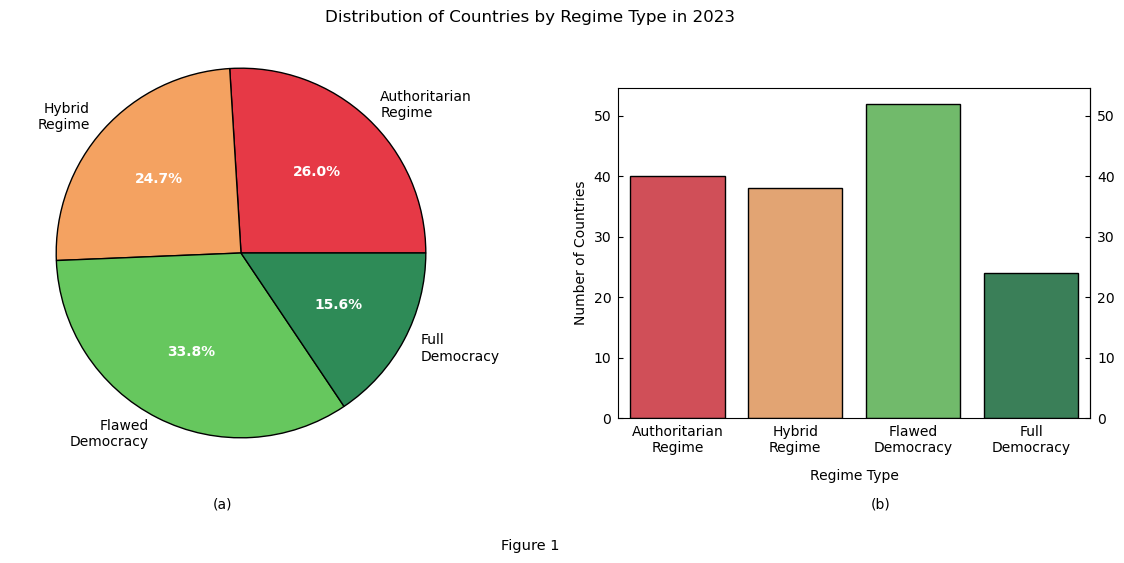

In [284]:
# Visualizing the df:

# Creating a new df with the count of countries grouped by regime type for 2023
type_dem = democracy_index[democracy_index['Year']==2023].groupby(['Type']).Country.count().reset_index(name='Count')

# Selecting colors for each regime type
color_type = ['#E63946', '#F4A261', '#66C75E', '#2E8B57']

# Setting up a figure to visualize the distribution of countries by regime type
fig1 = plt.figure(figsize=(14, 6))

# Setting the figure title
fig1.suptitle('Distribution of Countries by Regime Type in 2023', fontsize=12, y=0.9)

# Creating a subplot for the left graph: distribution of countries by regime type visualized as a pie chart
plt.subplot(1,2,1) 

# Creating a function to generate a pie chart, given the data and corresponding labels
def pie_plot(data,labels):

    # Generating the pie chart with percentage annotations, extracting some necessary parameters for later use
    wedges, texts, autotexts = plt.pie(data, labels=labels, wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%', 
                                       colors=color_type, textprops={'color': 'black'})

    # Setting the color of the percentage annotations
    [autotext.set_color('white') for autotext in autotexts]

    # Setting the weight of the percentage annotations
    [autotext.set_weight('bold') for autotext in autotexts] 

# Calling the function to create a pie chart using the specified data and labels
pie_plot(type_dem['Count'], type_dem['Type'])

# Creating a subplot for the right graph: distribution of countries by regime type visualized as a bar chart
plt.subplot(1,2,2)

# Creating the bar plot
ax_sub2_fig1 = sns.barplot(x='Type', y='Count', data=type_dem, palette=color_type,edgecolor='black')

# Setting the y-axis label 
ax_sub2_fig1.set_ylabel('Number of Countries')

# Setting the x-axis label
ax_sub2_fig1.set_xlabel('Regime Type',labelpad=10)

# Creating a function that modifies the ticks and adds secondary axes
# Input parameters:
# ax: axis handle
# no_x_ticks: boolean that determines whether x ticks are present or not (default: present)
# x2: boolean that determines whether a second x-axis should be created or not (default: no secondary x-axis)
def ticks_axes(ax, no_x_ticks=False, x2=False):

    # Setting the direction of the y-axis ticks inwards
    ax.tick_params(axis='y', direction='in', pad=5)

    # Setting the direction of the x-axis ticks inwards #newcomment
    ax.tick_params(axis='x', direction='in', pad=5)

    # If x ticks should be removed, override the previous x-axis tick settings
    if no_x_ticks:

        # Setting the tick length to 0 effectively hides the x-axis ticks
        ax.tick_params(axis='x', direction='in', pad=5, length=0)

    # Duplicating the y-axis on the right side
    ax_secondary_y = ax.secondary_yaxis('right')

    # Setting the ticks for the right y-axis
    ax_secondary_y.set_yticks(ax.get_yticks())

    # Setting the labels for the right y-axis
    ax_secondary_y.set_yticklabels(ax.get_yticklabels())

    # Setting the direction of the right y-axis ticks inwards
    ax_secondary_y.tick_params(axis='y', direction='in', pad=5)

    # If a secondary x-axis is desired, the following block is executed
    if x2:

        # Create a secondary x-axis on the top of the plot, similar to the secondary y-axis
        ax_secondary_x = ax.secondary_xaxis('top')

        ax_secondary_x.set_xticks(ax.get_xticks())

        ax_secondary_x.set_xticklabels(ax.get_xticklabels())

        ax_secondary_x.tick_params(axis='x', direction='in', pad=5)

# Calling the function to modify the ticks and add secondary axes to the specified axis
ticks_axes(ax_sub2_fig1, True)

# Adjusting the aspect ratio of the graph for a better fit within the figure
ax_sub2_fig1.set_aspect(0.7/ax_sub2_fig1.get_data_ratio())

# Creating space between both graphs in the figure
plt.subplots_adjust(wspace=0.3)

# Adding labels at the bottom of the figure
fig1.text(0.28, 0.07, '(a)', ha='center', fontsize=10)
fig1.text(0.75, 0.07, '(b)', ha='center', fontsize=10)
fig1.text(0.5, 0, 'Figure 1',
ha='center', fontsize=10.5)

# Displaying the plot
plt.show()

# Closing the plot
plt.close() 

Figure 1 illustrates the distribution of countries by regime type in 2023, presented both as a pie chart (Figure 1a) and a bar graph (Figure 1b). According to the Democracy Index, approximately half of the world's countries were democracies in 2023. Among these, one-third were classified as full democracies, while two-thirds were considered flawed democracies. About a quarter of the countries were under authoritarian rule, with the remaining quarter consisting of hybrid regimes that combine democratic and authoritarian characteristics.

Next, let's plot the distribution of countries by regime type from 2006 to 2023 in Figure 2 to examine any significant changes over the years.

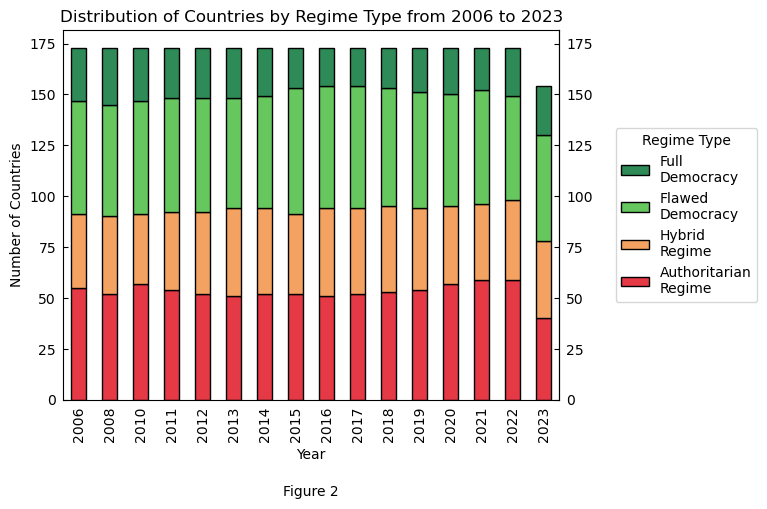

In [287]:
# Creating a df where years are rows and regime types are columns, derived from the original Democracy Index data,
# grouped by year and regime type
type_by_year = democracy_index.groupby(['Year','Type']).Country.count().unstack()

# Generating a stacked bar chart showing the number of countries per regime type each year, with years on the x-axis 
# and regime types stacked within each bar
ax_fig2 = type_by_year.plot(kind='bar', stacked=True,color=color_type,edgecolor='black')

# Retrieving the handles and labels to customize the plot legend
handles_fig2, labels_fig2 = ax_fig2.get_legend_handles_labels()

# Reversing the order of handles
handles_fig2 = handles_fig2[::-1]

# Reversing the order of labels
labels_fig2 = labels_fig2[::-1]

# Positioning the legend outside the plot for better readability using the extracted handles and labels
ax_fig2.legend(handles_fig2, labels_fig2,loc='center left', bbox_to_anchor=(1.1, 0.5), title='Regime Type')

ax_fig2.set_ylabel('Number of Countries')

ax_fig2.set_title('Distribution of Countries by Regime Type from 2006 to 2023')

plt.text(x=0.5, y=-0.25, s='Figure 2', ha='center', va='center', transform=ax_fig2.transAxes, fontsize=10)

ticks_axes(ax_fig2,True)

plt.show()

plt.close()

Figure 2 shows the proportions of regime types from 2006 to 2023. These proportions have remained relatively constant over this period, with only minor fluctuations. The lower number of countries listed in 2023 is likely due to incomplete data from certain regions at the time of data collection.

Let's upload and clean the raw data containing the population by country [6].

In [290]:
# Loading the population data by country into a df
world_population = csv_to_df(path_dataset_population,'","')

           Country Name,"Country Code"     "Indicator Name" "Indicator Code"  \
0                        "Aruba,""ABW"  "Population, total"    "SP.POP.TOTL"   
1  "Africa Eastern and Southern,""AFE"  "Population, total"    "SP.POP.TOTL"   
2                  "Afghanistan,""AFG"  "Population, total"    "SP.POP.TOTL"   
3   "Africa Western and Central,""AFW"  "Population, total"    "SP.POP.TOTL"   
4                       "Angola,""AGO"  "Population, total"    "SP.POP.TOTL"   

        "1960"       "1961"       "1962"       "1963"       "1964"  \
0      "54608"      "55811"      "56682"      "57475"      "58178"   
1  "130692579"  "134169237"  "137835590"  "141630546"  "145605995"   
2    "8622466"    "8790140"    "8969047"    "9157465"    "9355514"   
3   "97256290"   "99314028"  "101445032"  "103667517"  "105959979"   
4    "5357195"    "5441333"    "5521400"    "5599827"    "5673199"   

        "1965"       "1966"  ...       "2015"       "2016"       "2017"  \
0      "58782"      "59

In [291]:
# Cleaning the df:

# Splitting a column into separate columns
split_columns = world_population['Country Name,"Country Code"'].str.split(',', expand=True)

# Extracting the column with the world population data for 2023
world_population = world_population[['"2023"']]

# Adding the country names to the 2023 population data
world_population['Country'] = split_columns[0]

# Renaming columns for clarity
world_population = world_population.rename(columns={'"2023"': 'Population'})
 
# Removing quotation marks from the entries in the 'Country' and 'Population' columns
world_population[['Country', 'Population']] = world_population[['Country', 'Population']].apply(lambda x: x.str.replace('"', ''))
 
# Converting the population entries to numeric values
world_population['Population'] = world_population['Population'].replace('', np.nan).astype('float64')

print(world_population.head())

    Population                      Country
0     106277.0                        Aruba
1  739108306.0  Africa Eastern and Southern
2   42239854.0                  Afghanistan
3  502789511.0   Africa Western and Central
4   36684202.0                       Angola


Let's merge the cleaned datasets containing the Democracy Index and population data for each country.

In [293]:
# Merging dfs and cleaning the merged df:

# Merging Democracy Index data with population data for 2023
dem_pop = pd.merge(democracy_index[democracy_index['Year'] == 2023], world_population, on='Country', how='inner')
 
# Dropping unnecessary columns
dem_pop = dem_pop.drop(columns=['Year'])

# Excluding the 'World' entry from the country list (as it represents the total world population)
dem_pop = dem_pop[dem_pop['Country']!='World']

print(dem_pop.head())

     Country  Democracy_Index                   Type  Population
0    Albania             6.28      Flawed\nDemocracy   2745972.0
1    Algeria             3.66  Authoritarian\nRegime  45606480.0
2     Angola             4.18         Hybrid\nRegime  36684202.0
3  Argentina             6.62      Flawed\nDemocracy  46654581.0
4    Armenia             5.42         Hybrid\nRegime   2777970.0


Let's visualize the distribution of the world population by regime type for 2023 in Figure 3.

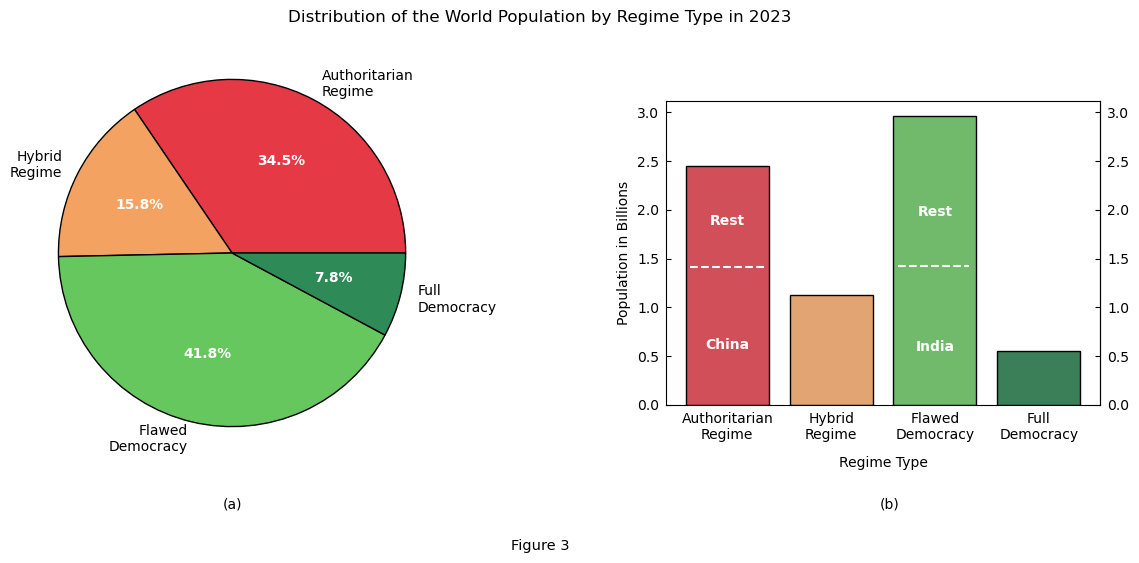

In [295]:
# Visualizing the df: 

# Creating a new df with the total population of countries grouped by regime type in 2023
type_pop = dem_pop.groupby(['Type']).Population.sum().reset_index(name='Sum')

fig3 = plt.figure(figsize=(14, 6))

fig3.suptitle('Distribution of the World Population by Regime Type in 2023', fontsize=12, y=0.9)

# Pie chart
plt.subplot(1,2,1)

pie_plot(type_pop['Sum'],type_pop['Type'])

# Copying the df for modification
type_pop_copy = type_pop.copy()

# Scaling the population column for better visualization (in billions)
type_pop_copy['Sum'] = type_pop_copy['Sum'] / 1e9

# Selecting regimes of interest
selected_regimes = ['Authoritarian\nRegime','Flawed\nDemocracy']

# Selecting columns of interest
selected_columns = ['Country','Population']

# Creating an empty list for annotations
annotations = [] 

# Looping through the selected regimes and columns
for regime in selected_regimes:
    
    for col in selected_columns:
        
        # Extracting entries for the selected regime type from the 'dem_pop' df
        dem_pop_reg = dem_pop[dem_pop['Type'] == regime]
        
        # Identifying the row for the country with the maximum population for the selected regime type
        row_max_pop = dem_pop_reg.loc[dem_pop_reg['Population'].idxmax()]
        
        # Obtaining the value for the selected column
        col_max_pop = row_max_pop[col]
        
        # Storing the values in the 'annotations' list
        annotations.append(col_max_pop)

# Bar chart
plt.subplot(1,2,2)

ax_sub2_fig3 = sns.barplot(x='Type', y='Sum', data=type_pop_copy, palette=color_type,edgecolor='black')

ax_sub2_fig3.set_ylabel('Population in Billions')

ax_sub2_fig3.set_xlabel('Regime Type',labelpad=10)

ax_sub2_fig3.set_xticklabels(ax_sub2_fig3.get_xticklabels(), rotation=0, ha='center')

# Setting the first bar, which represents the authoritarian regime
bar_index_ar = 0

# Retrieving the value associated with the bar
bar_value_ar = type_pop_copy.loc[bar_index_ar, 'Sum']

# Accessing the bar at the specified index
bar_ar = ax_sub2_fig3.patches[bar_index_ar] 

# Determining the starting x-coordinate of the bar
bar_ar_start = bar_ar.get_x()

# Determining the ending x-coordinate of the bar
bar_ar_end = bar_ar.get_x() + bar_ar.get_width()

# Adding a dashed horizontal line at the height of the maximum population for countries with an authoritarian regime
# (from the second entry in the 'annotations' array)
ax_sub2_fig3.hlines(annotations[1]/1e9, bar_ar_start/1.1, bar_ar_end/1.1, colors='white', linestyles='--')

# Setting the third bar, which represents the flawed democracy regime type, to add a similar horizontal line as for the authoritarian regime bar
bar_index_fd = 2  

bar_value_fd = type_pop_copy.loc[bar_index_fd, 'Sum']

bar_fd = ax_sub2_fig3.patches[bar_index_fd] 

bar_fd_start = bar_fd.get_x()

bar_fd_end = bar_fd.get_x() + bar_fd.get_width()

ax_sub2_fig3.hlines(annotations[3]/1e9, bar_fd_start*1.03, bar_fd_end/1.03, colors='white', linestyles='--')

# Annotating the country with the maximum population for authoritarian regimes, listed as the first entry in the 'annotations' array,
# below the dashed horizontal line
ax_sub2_fig3.text(bar_ar.get_x() + bar_ar.get_width() / 2, bar_ar.get_height() / 4,
    annotations[0], 
    ha='center', va='center', color='white', fontsize=10, weight='bold')

# Labeling the bar segment above the horizontal line as 'Rest,' representing the remaining population for the authoritarian regime type
ax_sub2_fig3.text(bar_ar.get_x() + bar_ar.get_width() / 2, bar_ar.get_height() / 1.3, 'Rest', ha='center', va='center', color='white', fontsize=10, weight='bold')

# Adding similar annotations for the flawed democracy bar
ax_sub2_fig3.text(bar_fd.get_x() + bar_fd.get_width() / 2, bar_fd.get_height() / 5,  
    annotations[2],  
    ha='center', va='center', color='white', fontsize=10, weight='bold')

ax_sub2_fig3.text(bar_fd.get_x() + bar_fd.get_width() / 2, bar_fd.get_height() / 1.5, 'Rest', ha='center', va='center', color='white', fontsize=10, weight='bold')

ticks_axes(ax_sub2_fig3, True)

ax_sub2_fig3.set_aspect(0.7/ax_sub2_fig3.get_data_ratio())

# Creating space between both graphs in the figure
plt.subplots_adjust(wspace=0.5)

# Adding labels at the bottom of the figure
fig3.text(0.28, 0.07, '(a)', ha='center', fontsize=10)
fig3.text(0.75, 0.07, '(b)', ha='center', fontsize=10)
fig3.text(0.5, 0, 'Figure 3',
ha='center', fontsize=10.5)

plt.show()

plt.close() 

Figure 3 depicts the distribution of the world population by regime type in 2023, presented both as a pie chart (Figure 3a) and a bar graph (Figure 3b). The data reveal that in 2023, approximately half of the world’s population (of the listed countries), around 3.5 billion people, lived in democracies, a proportion that mirrors the distribution of democratic countries depicted in Figure 1. However, while Figure 1 indicates a 1:2 ratio of full to flawed democracies, the population ratio is closer to 1:6. This discrepancy arises because countries with flawed democracies typically have larger populations than those with full democracies. Notably, India, with a population of approximately 1.4 billion people, makes up half of the population in flawed democracies, constituting a significant portion of those living in flawed democracies (see Figure 1b). Although about a quarter of the world’s countries were under authoritarian regimes, these nations accounted for roughly a third of the global population, or approximately 2.5 billion people, with China alone representing more than half of that figure at around 1.4 billion people. While around a quarter of countries were classified as hybrid regimes, these nations comprised about a fifth of the world’s population, or approximately 1.1 billion people.

Next, let's upload and clean the raw data containing the press freedom scores by country [3]. The scores range from 0 to 100%.

In [298]:
# Loading the press freedom scores by country into a df  
press_freedom_index = csv_to_df(path_dataset_press_freedom,';')

   ISO  Score  Rank Political Context  Rank_Pol Economic Context  Rank_Eco  \
0  NOR  95,18     1             96,54         1            92,46         1   
1  IRL  89,91     2             93,91         2            82,11         7   
2  DNK  89,48     3             91,95         4            85,17         4   
3  SWE  88,15     4             92,58         3            86,08         3   
4  FIN  87,94     5             91,55         5             83,8         5   

  Legal Context  Rank_Leg Social Context  ...  Country_EN Country_ES  \
0         94,92         1          95,98  ...      Norway    Noruega   
1         82,55        19          94,03  ...     Ireland    Irlanda   
2          87,5         5          87,78  ...     Denmark  Dinamarca   
3         88,74         4          88,64  ...      Sweden     Suecia   
4         84,86        11          89,17  ...     Finland  Finlandia   

   Country_PT Country_AR Country_FA Year (N) Rank N-1 Rank evolution  \
0    Noruega     النرويج  

In [299]:
# Cleaning the df:

# Keeping only the necessary columns
press_freedom_index = press_freedom_index[['Country_EN','Score','Year (N)']]

# Renaming the columns for clarity
press_freedom_index = press_freedom_index.rename(columns={'Country_EN': 'Country', 'Score': 'Press_Freedom_Score','Year (N)': 'Year'})

# Replacing commas with periods in the Press Freedom Score
press_freedom_index['Press_Freedom_Score'] = press_freedom_index['Press_Freedom_Score'].str.replace(',','.')

# Converting Press Freedom Score entries from string to float
press_freedom_index['Press_Freedom_Score'] = press_freedom_index['Press_Freedom_Score'].astype('float64')

print(press_freedom_index.head())

print('---')

print(press_freedom_index.info())

print('---')

   Country  Press_Freedom_Score  Year
0   Norway                95.18  2023
1  Ireland                89.91  2023
2  Denmark                89.48  2023
3   Sweden                88.15  2023
4  Finland                87.94  2023
---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              180 non-null    object 
 1   Press_Freedom_Score  180 non-null    float64
 2   Year                 180 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.3+ KB
None
---


Let's merge the cleaned datasets containing the Democracy Index and press freedom scores.

In [301]:
# Merging dfs and cleaning the merged df:
  
# Merging the Democracy Index and press freedom data
democracy_press = pd.merge(democracy_index, press_freedom_index, on=['Country','Year'], how='inner')

# Dropping unnecessary columns
democracy_press = democracy_press.drop(columns=['Year'])

print(democracy_press.head())

     Country  Democracy_Index                   Type  Press_Freedom_Score
0    Albania             6.28      Flawed\nDemocracy                57.86
1    Algeria             3.66  Authoritarian\nRegime                45.74
2     Angola             4.18         Hybrid\nRegime                48.30
3  Argentina             6.62      Flawed\nDemocracy                73.36
4    Armenia             5.42         Hybrid\nRegime                70.61


Let's analyze the correlation between the Democracy Index and Press Freedom through statistical analysis.

In [303]:
# Statistical analysis of the correlation between democracy and press freedom:

# Creating a function for the statistical analysis, taking two input parameters of interest
def stat(x_data,y_data):

    # Initializing a linear regression model from the scikit-learn library
    reg = LinearRegression()
    
    # Extracting the first parameter (x_data) as a NumPy array and reshape it from 1D to 2D for compatibility with the regression model
    x = x_data.values.reshape(-1, 1)
    
    # Extracting the second parameter (y_data) as a NumPy array
    y = y_data.values
    
    # Performing a linear fit (regression) between the two parameters
    reg.fit(x,y)
    
    # Predicting the values of the second parameter (y_data) based on the first parameter (x_data) using the linear regression model
    y_fit = reg.predict(x)
    
    # Calculating the Pearson correlation coefficient (r) between the two parameters to measure the strength and direction of their linear relationship
    r, _ = pearsonr(x_data, y_data)
    
    # Calculating the R-squared (R²) coefficient to determine the proportion of variance in the dependent variable 
    # that is predictable from the independent variable
    r_sq = reg.score(x,y)
    
    # Creating a dictionary to store the calculated statistical parameters
    stat = {
    'Parameter': ['r','R$^{2}$'],
    'Value': [round(r,2),round(r_sq,2)]
    }
    
    # Converting the dictionary into a df 
    stat_df = pd.DataFrame(stat)
    
    # Transposing the df to swap rows and columns
    stat_df = stat_df.T
    
    # Setting the first row as the column headers
    stat_df.columns = stat_df.iloc[0]
    
    # Removing the first row
    stat_df = stat_df.drop(stat_df.index[0])
    
    # Resetting the index
    stat_df.reset_index(inplace=True)
    
    # Renaming the first entry in the df to 'Parameter'
    stat_df.rename(columns={'index': 'Parameter'}, inplace=True)

    # Returning the df with the statistical parameters, the reshaped x values, and the predicted y values
    return (stat_df,x,y_fit)

# Calling the function with the Democracy Index and press freedom score as input parameters
stat_df_dp, x_dp, y_fit_dp = stat(democracy_press['Democracy_Index'],democracy_press['Press_Freedom_Score'])

Let's identify the countries with the minimum and maximum press freedom scores within each regime type.

In [305]:
# Extracting key values from the df:

# Creating a function to extract the minimum and maximum values per regime type 
# Input parameters:
# label: the label for the third column in the resulting table
# df_data: the df containing the data of interest
# column: the parameter of interest (contained in the df)
# regime_types: list of the regime_types
def minmax(label, df_data, column, regime_types):

    # List of column names for the new table
    list_columns = ['Regime Type','Min/Max',label,'Country','Democracy Index']
    
    # Creating an empty df with the specified columns
    df_minmax = pd.DataFrame(columns=list_columns)
    
    # Initializing a counter for the upcoming loop, starting at 0
    count = 0
    
    # Looping through each regime type to extract the countries with the minimum and maximum values for the specified parameter
    for type in regime_types:
    
        # Finding the index of the country with the minimum value for the specified parameter within the current regime type
        min_index = df_data[df_data['Type'] == type][column].idxmin()
    
        # Extracting the row corresponding to the minimum value
        min_type = df_data.loc[min_index]
    
        # Finding the index of the country with the maximum value for the specified parameter within the current regime type
        max_index = df_data[df_data['Type'] == type][column].idxmax()
    
        # Extracting the row for the country with the maximum parameter
        max_type = df_data.loc[max_index]
    
        # Creating a list for the country with the minimum parameter, including regime type, 'Min' tag, press freedom score, 
        #country name, and specified parameter
        min_list = [type,'Min',round(min_type[3],1),min_type[0],round(min_type[1],1)]
        
        # Creating a similar list for the country with the maximum parameter, including the 'Max' tag
        max_list = [type,'Max',round(max_type[3],1),max_type[0],round(max_type[1],1)]
        
        # Adding the list with the 'Min' tag as a new row in df_minmax
        df_minmax.loc[count] = min_list
    
        # Adding the list with the 'Max' tag as a new row in df_minmax
        df_minmax.loc[count+1] = max_list
        
        # Incrementing the counter by 2 at the end of each loop iteration, as two rows are added per iteration
        count += 2
        
    # Returning the created df with the minimum and maximum values #newcomment
    return df_minmax

# Calling the function with the input data for the press freedom score
df_minmax_dp = minmax('Press Freedom\nScore (%)', democracy_press, 'Press_Freedom_Score', regime_types)

Let’s visualize the correlation between the Democracy Index and press freedom score for 2023 in Figure 4.  
Additionally, we’ll list the countries with the minimum and maximum press freedom scores within each regime type for 2023 in Table 1.

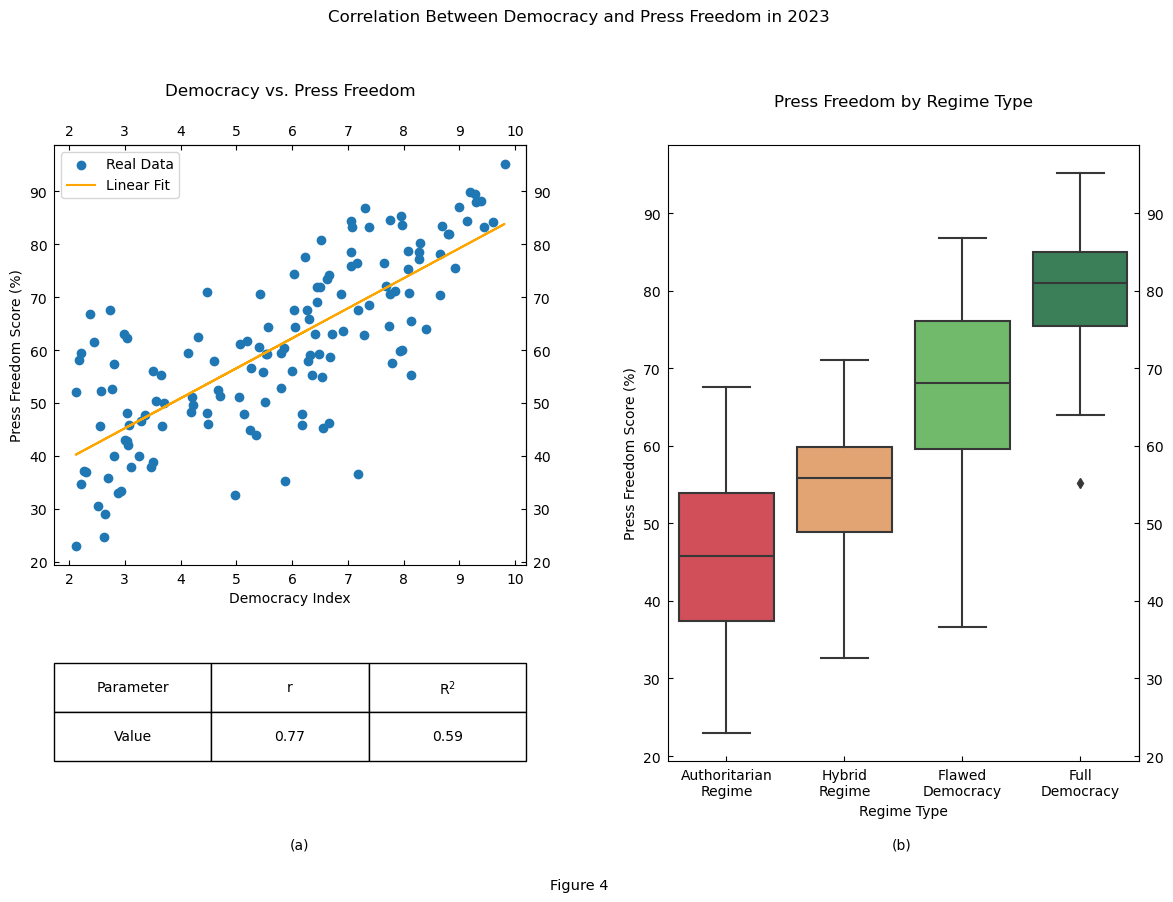

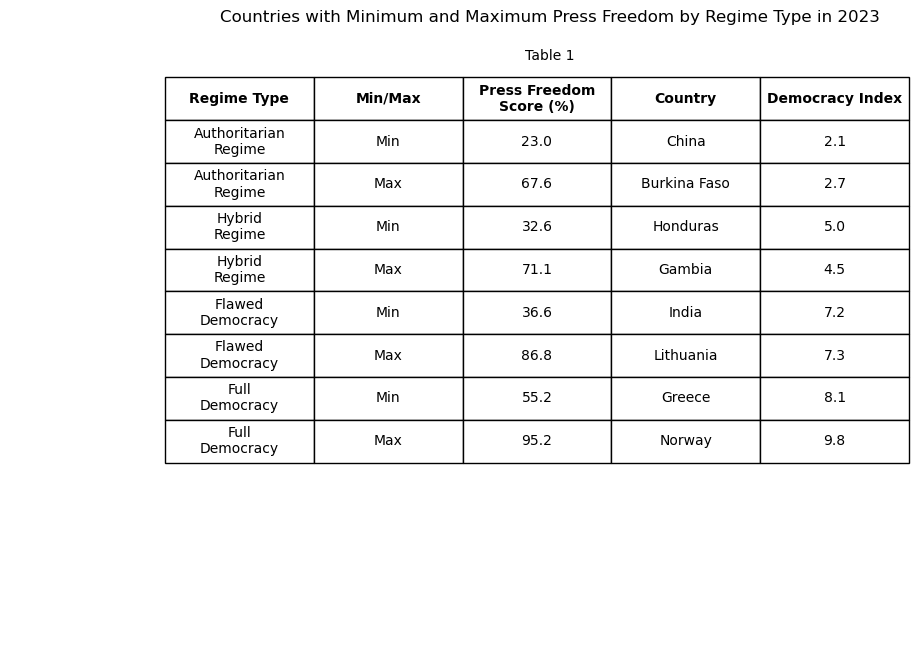

In [307]:
# Visualization: 

# Creating a function for plotting a scatter plot with a linear fit and fit parameters, box plots per regime type, 
# and a table with minimum and maximum values of the parameter of interest
def plot(fig_title, # Figure title  
         df_data, # df containing the parameters of interest 
         col_x, # Parameter 1 ("x parameter") contained in the df
         col_y, # Parameter 2 ("y parameter") contained in the df
         x, # x values for the linear fit line
         y_fit, # y values for the linear fit line 
         sub1_title, # Title of the scatter plot
         sub1_xlabel, # x label of the scatter plot
         ylabel, # y label for both the scatter and box plots
         sub2_title, # Title of the box plot
         sub2_xlabel, # x label of the box plot
         stat_df, # df containing the statistical parameters
         fig_num, # Number of the figure
         tab_title, # Title of the table
         tab_num, # Table number
         df_minmax): # df containing the minimum and maximum values of the "y parameter"

    fig_I = plt.figure(figsize=(14, 8))
    
    # Defining height ratios for the subplots
    gs = fig_I.add_gridspec(2, 2, height_ratios=[3, 1])
    
    fig_I.suptitle(fig_title, fontsize=12, y=1.05)
    
    # Scatter plot with linear fit
    ax1 = fig_I.add_subplot(gs[0, 0])
    
    # Creating a scatter plot of the two parameters of interest
    ax1.scatter(df_data[col_x],df_data[col_y],label='Real Data')
     
    # Adding the linear fit line
    ax1.plot(x,y_fit,color='orange',label='Linear Fit')
    
    ax1.set_title(sub1_title, y=1.1)
    
    ax1.set_ylabel(ylabel)
    
    ax1.set_xlabel(sub1_xlabel)
    
    ax1.legend()
    
    ticks_axes(ax1, False, True)
    
    # Box plot
    ax2 = fig_I.add_subplot(gs[:, 1])
    
    # Creating a box plot of the parameter of interest for each regime type
    sns.boxplot(x='Type', y=col_y, data=df_data, palette=color_type)
    
    ax2.set_title(sub2_title, y=1.05)
    
    ax2.set_ylabel(ylabel)
    
    ax2.set_xlabel(sub2_xlabel)
    
    ticks_axes(ax2)
    
    # Table
    ax3 = fig_I.add_subplot(gs[1, 0])
    
    # Turning off the axis since we only want to display the table
    ax3.axis('off')
    
    # Creating a table from the df with the statistical parameters
    table = ax3.table(cellText=stat_df.values, colLabels=stat_df.columns, cellLoc='center', loc='center',bbox=[0, 0, 1, 0.7])
    
    # Adding space between the scatter plot and the box plot
    plt.subplots_adjust(wspace=0.3)
    
    # Adding subplot labels
    fig_I.text(0.3, -0.0, '(a)', ha='center', fontsize=10)
    fig_I.text(0.73, -0.0, '(b)', ha='center', fontsize=10)
    
    # Adding figure label
    fig_I.text(0.5, -0.05, fig_num, ha='center', fontsize=10.5)
    
    plt.show()
    
    plt.close()
    
    print("\n" * 5)
    
    # Creating a new figure for the table listing countries with minimum and maximum parameter of interest by regime type #newcomment
    fig_II, ax4 = plt.subplots(figsize=(8, 5))
    
    fig_II.suptitle(tab_title, fontsize=12, y=1.4, x = 0.8,ha='center')
    
    fig_II.text(0.8, 1.3, tab_num, ha='center', fontsize=10)
    
    ax4.axis('off')
    
    table2 = ax4.table(cellText=df_minmax.values, colLabels=df_minmax.columns, cellLoc='center', loc='center',bbox=[0.25, 0.5, 1.2, 1])
    
    # Disabling automatic font sizing
    table2.auto_set_font_size(False)
    
    # CHANGE
    
    # Setting a custom font size
    table2.set_fontsize(10)  
    
    # Iterating through each cell in the table
    for (i, j), cell in table2.get_celld().items():
    
        # Making the header row bold
        if i == 0:
                
            cell.set_text_props(fontweight='bold')
            
    plt.show()
    
    plt.close()

# Calling the function to create correlation plots between the Democracy Index and press freedom score
plot('Correlation Between Democracy and Press Freedom in 2023', 
     democracy_press, 
     'Democracy_Index', 
     'Press_Freedom_Score', 
     x_dp, 
     y_fit_dp, 
     'Democracy vs. Press Freedom', 
     'Democracy Index', 
     'Press Freedom Score (%)', 
     'Press Freedom by Regime Type', 
     'Regime Type', 
     stat_df_dp, 
     'Figure 4', 
     'Countries with Minimum and Maximum Press Freedom by Regime Type in 2023', 
     'Table 1', 
     df_minmax_dp)

Figure 4 visualizes the correlation between the Democracy Index and the press freedom scores of countries in 2023, with the latter ranging from 0% to 100%. Figure 4a shows a scatter plot of the press freedom scores over the Democracy Index, along with a linear fit line. The Pearson coefficient (r) and coefficient of determination (R<sup>2</sup>) are displayed below the scatter plot, with the results showing a strong positive linear correlation between the Democracy Index and press freedom score, indicated by r = 0.77. R<sup>2</sup> = 0.59 suggests that 59% of the variation in press freedom scores can be explained by differences in the Democracy Index. This underscores the significant relationship between higher levels of democracy and increased press freedom. 

Figure 4b presents a box plot comparison of press freedom scores across different regime types, showing a clear upward trend in median press freedom scores from authoritarian regimes to full democracies. This trend reinforces the positive correlation observed in Figure 4a. Notably, the variability in press freedom scores within full democracies is narrower than in flawed democracies, indicating more consistent levels of press freedom in full democracies.

Table 1 complements the insights from Figure 4b by listing countries with the minimum and maximum press freedom scores within each regime type. This table highlights notable exceptions to the general trend. For instance, India, despite being classified as a flawed democracy, had a relatively low press freedom score, nearly equivalent to Honduras (the country with the lowest press freedom score among hybrid regimes) and China (which had the lowest score among authoritarian regimes and indeed the lowest score of all countries analyzed). On the other hand, Gambia (which had the highest press freedom score among hybrid regimes) and Burkina Faso (which had the highest score among authoritarian regimes) both achieved higher press freedom scores than India, despite having lower democracy indices. This suggests that while there is a strong correlation between democracy and press freedom, significant outliers exist where less democratic countries can maintain relatively high levels of press freedom. Additionally, while China had the lowest press freedom score of all the countries listed, Norway was at the opposite end of the spectrum with the highest press freedom score.

Next, let's upload and clean the raw data on life expectancy by country [4].

In [310]:
# Uploading life expectancy data by country into a df
life_expectancy = csv_to_df(path_dataset_life_expectancy,'","')

           Country Name,"Country Code"  \
0                        "Aruba,""ABW"   
1  "Africa Eastern and Southern,""AFE"   
2                  "Afghanistan,""AFG"   
3   "Africa Western and Central,""AFW"   
4                       "Angola,""AGO"   

                            "Indicator Name"  "Indicator Code"  \
0  "Life expectancy at birth, total (years)"  "SP.DYN.LE00.IN"   
1  "Life expectancy at birth, total (years)"  "SP.DYN.LE00.IN"   
2  "Life expectancy at birth, total (years)"  "SP.DYN.LE00.IN"   
3  "Life expectancy at birth, total (years)"  "SP.DYN.LE00.IN"   
4  "Life expectancy at birth, total (years)"  "SP.DYN.LE00.IN"   

               "1960"              "1961"              "1962"  \
0            "64.152"            "64.537"            "64.752"   
1  "44.0855518454965"   "44.386696928982"  "44.7521818697994"   
2            "32.535"            "33.068"            "33.547"   
3  "37.8451516181524"  "38.1649497795417"  "38.7351018609467"   
4            "38.211"    

In [311]:
# Cleaning the df

# Dropping unnecessary columns
life_expectancy = life_expectancy.drop(columns=['Unnamed: 67'])

# Removing quotation marks from the DataFrame entries
life_expectancy = life_expectancy.apply(lambda x: x.str.replace('"', ''))

# Splitting the 'Country Name,"Country Code"' column into separate columns
life_expectancy[['Country','Code','.']] = life_expectancy['Country Name,"Country Code"'].str.split(',', expand=True)

# Extracting life expectancy data for 2022
le_2022 = life_expectancy[['Country','"2022"']]

# Renaming columns for clarity
le_2022 = le_2022.rename(columns={'"2022"': 'Life_Exp'})

# Converting life expectancy values from strings to floats
le_2022['Life_Exp'] = le_2022['Life_Exp'].replace('',np.nan).astype('float64')

print(le_2022.head())

                       Country   Life_Exp
0                        Aruba  74.992000
1  Africa Eastern and Southern  62.899031
2                  Afghanistan  62.879000
3   Africa Western and Central  57.626176
4                       Angola  61.929000


Let's merge the cleaned datasets containing the Democracy Index and life expectancy data.

In [313]:
# Merging dfs and cleaning the merged df:

# Merging the Democracy Index and life expectancy data for 2022
dem_le = pd.merge(democracy_index[democracy_index['Year'] == 2022], le_2022, on='Country', how='inner')

# Dropping unnecessary columns
dem_le = dem_le.drop(columns=['Year'])

print(dem_le.head())

       Country  Democracy_Index                   Type  Life_Exp
0  Afghanistan             0.32  Authoritarian\nRegime    62.879
1      Albania             6.41      Flawed\nDemocracy    76.833
2      Algeria             3.66  Authoritarian\nRegime    77.129
3       Angola             3.96  Authoritarian\nRegime    61.929
4    Argentina             6.85      Flawed\nDemocracy    76.064


Let's analyze and visualize the correlation between the Democracy Index and life expectancy in 2022 (see Figure 5 and Table 2). 

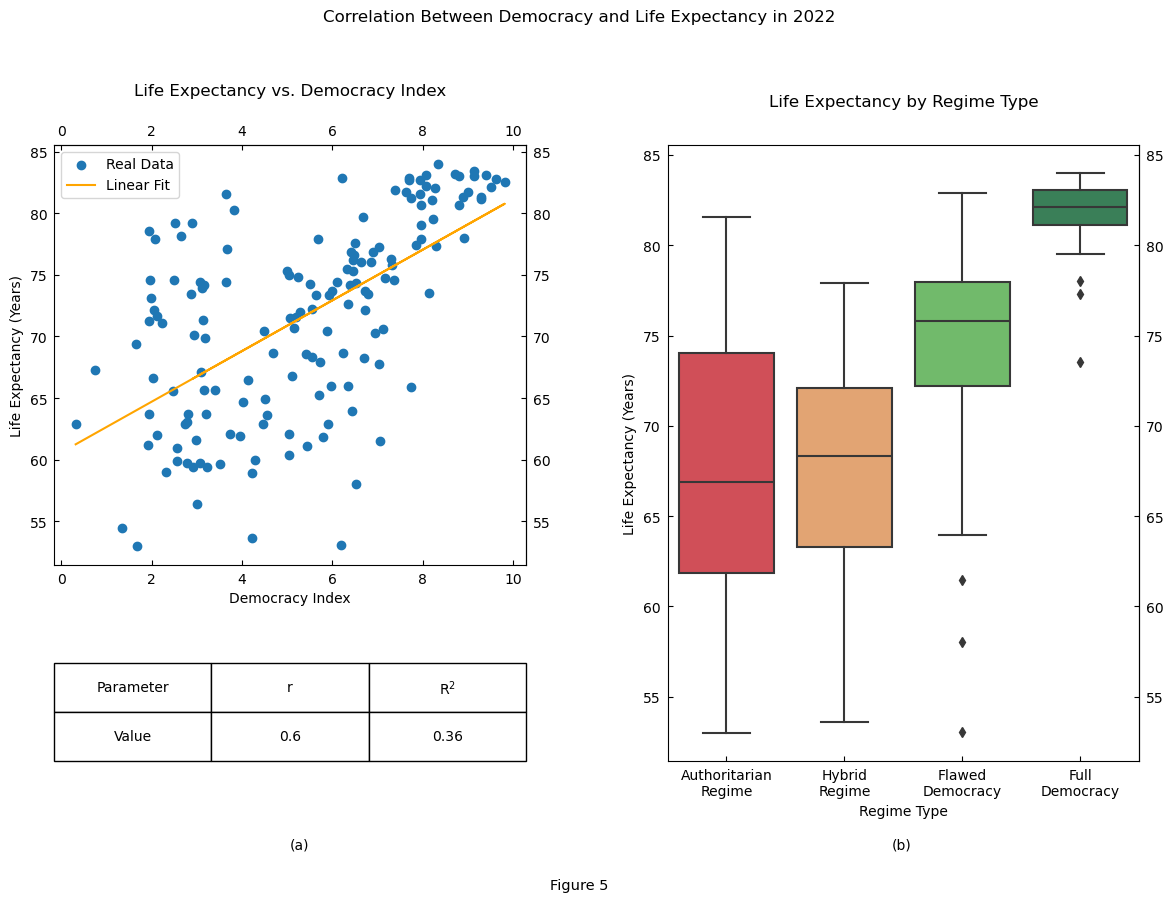

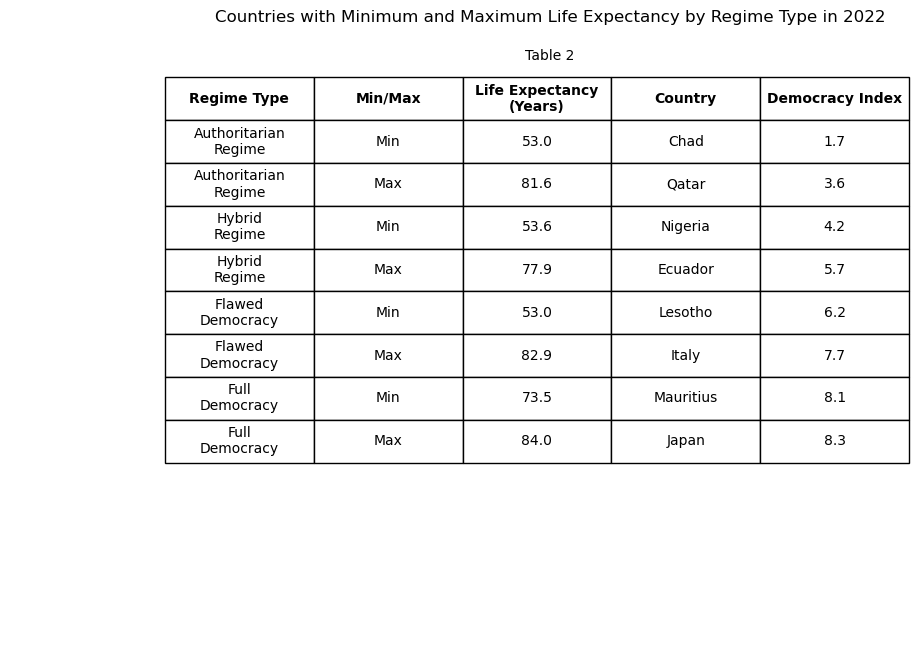

In [315]:
# Linear regression and further statistical analysis:
stat_df_dl, x_dl, y_fit_dl = stat(dem_le['Democracy_Index'],dem_le['Life_Exp'])

# Extracting key values from the df:
df_minmax_dl = minmax('Life Expectancy\n(Years)', dem_le, 'Life_Exp', regime_types)

# Visualization:
plot('Correlation Between Democracy and Life Expectancy in 2022', 
     dem_le, 
     'Democracy_Index', 
     'Life_Exp', 
     x_dl, 
     y_fit_dl, 
     'Life Expectancy vs. Democracy Index', 
     'Democracy Index', 
     'Life Expectancy (Years)', 
     'Life Expectancy by Regime Type', 
     'Regime Type', 
     stat_df_dl, 
     'Figure 5', 
     'Countries with Minimum and Maximum Life Expectancy by Regime Type in 2022', 
     'Table 2', 
     df_minmax_dl)

Figure 5, which follows a structure similar to Figure 4, visualizes the correlation between the Democracy Index and life expectancy in 2022. Figure 5a indicates a moderate positive linear correlation between the Democracy Index and life expectancy, as shown by r = 0.6. R<sup>2</sup> = 0.36 suggests that 36% of the variation in life expectancy can be explained by differences in the Democracy Index. This indicates that while democracy is a significant factor in determining life expectancy, other factors also play a considerable role. 

Figure 5b displays a clear upward trend in the median life expectancy from authoritarian regimes to full democracies, reinforcing the positive correlation observed in Figure 5a. Additionally, the variability in life expectancy decreases from authoritarian regimes to full democracies, indicating more consistent life expectancy levels in countries with higher democracy indices. Life expectancy tends to be relatively high in democracies, especially in full democracies.

Table 2 provides a detailed look at the countries with the minimum and maximum life expectancies within each regime type, as discussed in Figure 5b. The table reveals that the minimum life expectancies for authoritarian regimes (Chad, which has the lowest of all countries), hybrid regimes (Nigeria), and flawed democracies (Lesotho) were relatively similar, hovering around the mid-50s. In contrast, the minimum life expectancy for full democracies (Mauritius) was approximately 20 years higher. Interestingly, the maximum life expectancies across different regime types were fairly similar, with Japan (a full democracy) having the highest life expectancy of all countries. Notably, Qatar, which had the highest life expectancy among authoritarian regimes, surpassed the life expectancies of countries with the minimum life expectancy in other regime types. This highlights that while more democratic countries generally had higher life expectancies, there are exceptions where less democratic countries still achieved relatively high life expectancy rates.

Next, let's upload and clean the raw data on the percentage of GDP spent on education by country (referred to as "gdp_edu") [5].

In [318]:
# Uploading the gdp_edu data per country into a df
edu = csv_to_df(path_dataset_education)

  Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4      Albania          ALB   

                                              Series        Series Code  \
0  Government expenditure on education as % of GD...  SE.XPD.TOTL.GD.ZS   
1         Gross enrolment ratio, primary, female (%)     SE.PRM.ENRR.FE   
2  Gross enrolment ratio, primary, gender parity ...  SE.ENR.PRIM.FM.ZS   
3  Out-of-school children of primary school age, ...        SE.PRM.UNER   
4  Government expenditure on education as % of GD...  SE.XPD.TOTL.GD.ZS   

  2014 [YR2014] 2015 [YR2015] 2016 [YR2016] 2017 [YR2017] 2018 [YR2018]  \
0       3.69522        3.2558       4.22836       4.05887            ..   
1       86.7296      83.50442      82.55836      82.08028      82.85025   
2       0.69825       0.68081       0.67937       0.67617       0.66691   
3            ..            ..            ..            ..     

In [319]:
# Cleaning the df:

# Replacing all entries of '..' with null values
edu = edu.replace('..',np.nan)

# Filtering the data to include only entries related to GDP spent on education (gdp_edu)
edu = edu[edu['Series'] == 'Government expenditure on education as % of GDP (%)']

# Extracting gdp_edu from 2014
edu_2014 = edu[['Country Name','2014 [YR2014]']]

# Renaming columns for clarity
edu_2014 = edu_2014.rename(columns={'Country Name': 'Country','2014 [YR2014]': 'EDI'})

# Converting the data type from strings to floats
edu_2014['EDI'] = edu_2014['EDI'].astype('float64')

print(edu_2014[edu_2014['EDI'].notna()].head())

        Country      EDI
0   Afghanistan  3.69522
16      Andorra  3.07421
36    Argentina  5.36144
40      Armenia  2.24724
44        Aruba  5.90521


Let's merge the cleaned data containing the Democracy Index and gdp_edu.

In [321]:
# Mering dfs and cleaning the merged df:

# Merging the Democracy Index data with the gdp_edu data
dem_edu = pd.merge(democracy_index[democracy_index['Year'] == 2014], edu_2014, on='Country', how='inner')

# Dropping unnecessary columns
dem_edu = dem_edu.drop(columns=['Year'])

# Removing rows with null values
dem_edu = dem_edu.dropna()

print(dem_edu.head())

       Country  Democracy_Index                   Type      EDI
0  Afghanistan             2.77  Authoritarian\nRegime  3.69522
4    Argentina             6.84      Flawed\nDemocracy  5.36144
5      Armenia             4.13         Hybrid\nRegime  2.24724
6    Australia             9.01        Full\nDemocracy  5.16477
7      Austria             8.54        Full\nDemocracy  5.44762


Let's analyze and visualize the correlation between the Democracy Index and gdp_edu in 2014 (see Figure 6 and Table 3). 

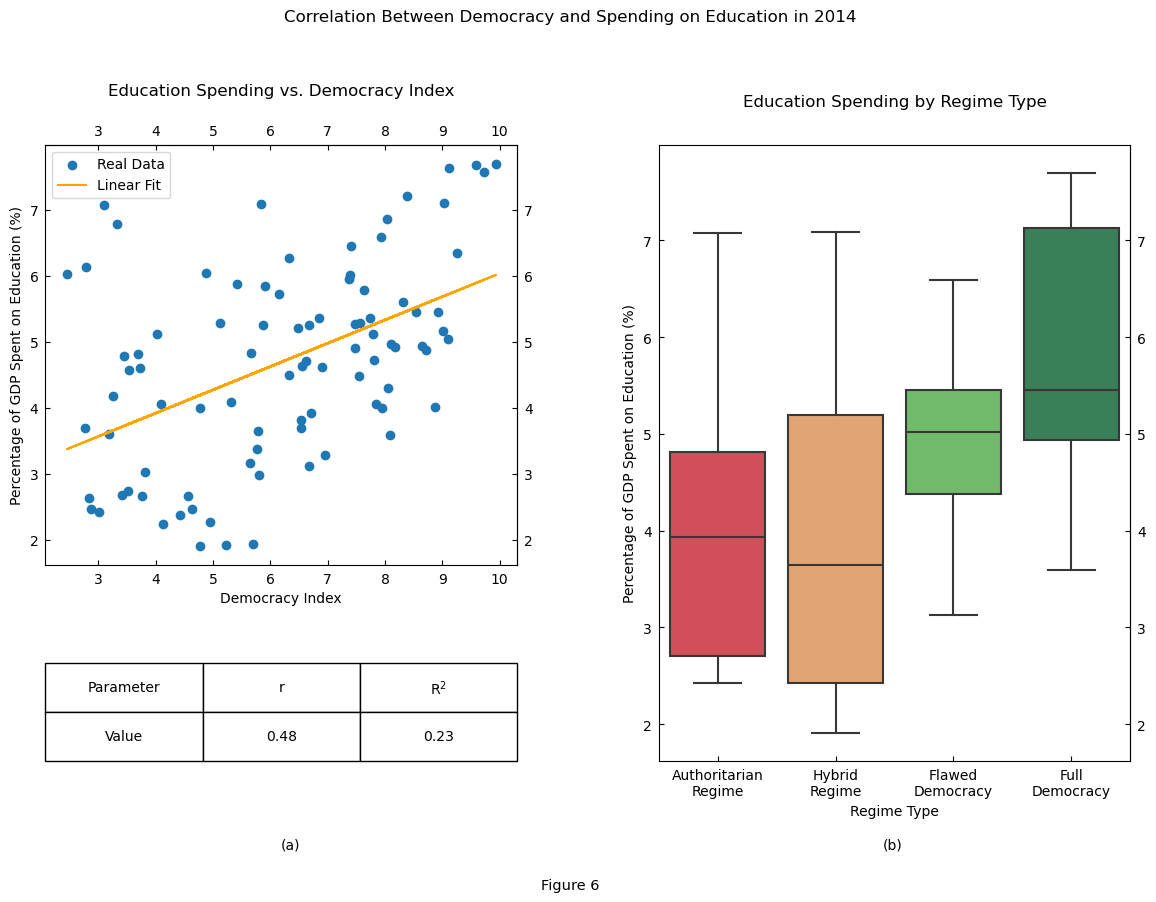

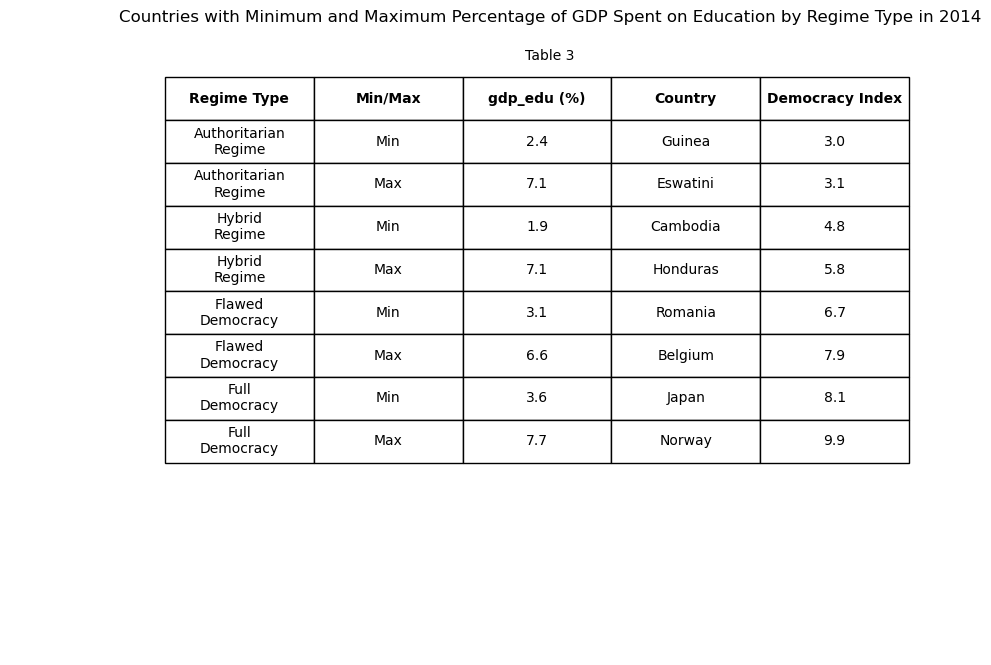

In [323]:
# Linear regression and further statistical analysis:
stat_df_de, x_de, y_fit_de = stat(dem_edu['Democracy_Index'],dem_edu['EDI'])

# Extracting key values from the df:
df_minmax_de = minmax('gdp_edu (%)', dem_edu, 'EDI', regime_types)

# Visualization:
plot('Correlation Between Democracy and Spending on Education in 2014', 
     dem_edu, 
     'Democracy_Index', 
     'EDI', 
     x_de, 
     y_fit_de, 
     'Education Spending vs. Democracy Index', 
     'Democracy Index', 
     'Percentage of GDP Spent on Education (%)', 
     'Education Spending by Regime Type', 
     'Regime Type', 
     stat_df_de, 
     'Figure 6', 
     'Countries with Minimum and Maximum Percentage of GDP Spent on Education by Regime Type in 2014', 
     'Table 3', 
     df_minmax_de)

Figure 6, structured similarly to Figures 4 and 5, visualizes the correlation between the Democracy Index and government spending on education as a percentage of GDP in 2014. Figure 6a indicates a moderate positive linear correlation between the Democracy Index and education spending, as shown by r = 0.48. R<sup>2</sup> = 0.23 suggests that 23% of the variation in education spending can be explained by differences in the Democracy Index. This indicates that while democracy contributes to higher education spending, other factors also play a substantial role. The data reveal that countries generally spent between 2% and 8% of their GDP on education in 2014. 

Figure 6b shows that both authoritarian and hybrid regimes have similar median education spending levels, whereas democracies exhibit significantly higher median spending. Moreover, the interquartile range for full democracies lies within a generally higher spectrum compared to flawed democracies, indicating more consistent and higher investment in education among full democracies.

Table 3 provides a detailed examination of the countries with the minimum and maximum education spending (gdp_edu (%)) within each regime type, complementing the insights from Figure 6b. The table reveals that the minimum and maximum life expectancies were roughly similar, respectively. Notably, Belgium, which had the lowest education spending among flawed democracies, spent less on education than Honduras (which had the highest education spending among hybrid regimes) and Eswatini (which had the highest spending among authoritarian regimes). Moreover, Eswatini's education spending was higher than that of Japan, which had the lowest spending among full democracies. In this context, it is interesting to observe that Japan, despite having the lowest education spending among full democracies in 2014, boasted the highest life expectancy in 2022 (as seen in Table 2). Notably, Cambodia, a hybrid regime, spent the least on education across all countries, while Norway, a full democracy, spent the most. In this context, Norway not only had the highest education spending in 2014 but also had the highest press freedom score in 2023 (as seen in Table 1), both among full democracies and across all countries.

To sum up this analysis, here are the key conclusions:
- According to the Economist’s Democracy Index, approximately half of the world’s countries are classified as democracies (see Figure 1).
- Around half of the global population resides in countries that are classified as democratic (see Figure 2). 
- The proportions of different regime types have remained relatively stable over the past 20 years, showing little significant change (see Figure 3).
- There is a strong positive correlation between the level of democracy and press freedom, indicating that more democratic countries tend to enjoy greater press freedom (see Figure 4).
- A moderate positive correlation exists between democracy and life expectancy, suggesting that democratic countries generally have higher life expectancies (see Figure 5).
- There is also a moderate positive correlation between democracy and government spending on education, though this correlation is weaker than that between democracy and life expectancy (see Figure 6).
- Figures 4-6 support the intuitive assumption of a positive correlation between democracy and press freedom, life expectancy, and education spending. However, there are notable exceptions where this pattern does not hold.

If you are interested in further analysis, feel free to reach out!

References:  
[1] https://www.eiu.com/n/campaigns/democracy-index-2023/  
[2] https://ourworldindata.org/grapher/democracy-index-eiu?tab=table&time=2006..2023    
[3] https://rsf.org/en/index  
[4] https://data.worldbank.org/indicator/SP.DYN.LE00.IN  
[5] https://databank.worldbank.org/source/education-statistics-%5e-all-indicators/preview/on#   
[6] https://data.worldbank.org/indicator/SP.POP.TOTL?most_recent_year_desc=true